In [3]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from mindquantum.core.gates import X
from mindquantum.core.circuit import Circuit
from mindquantum.core.operators import Hamiltonian
from mindquantum.simulator import Simulator
from mindquantum.algorithm.nisq import generate_uccsd
import mindspore as ms
import numpy as np
from scipy.optimize import minimize

In [4]:
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

def bound_state_energy(dist):
    #dist = 1.545
    geometry = [
        ["Li", [0.0, 0.0, 0.0 * dist]],
        ["H", [0.0, 0.0, 1.0 * dist]],
    ]
    basis = "sto3g"
    spin = 0
    #print("Geometry: \n", geometry)

    molecule_of = MolecularData(
        geometry,
        basis,
        multiplicity=2 * spin + 1
    )
    molecule_of = run_pyscf(
        molecule_of,
        run_scf=1,
        run_ccsd=1,
        run_fci=1
    )

    #print("Hartree-Fock energy: %20.16f Ha" % (molecule_of.hf_energy))
    #print("CCSD energy: %20.16f Ha" % (molecule_of.ccsd_energy))
    #print("FCI energy: %20.16f Ha" % (molecule_of.fci_energy))

    molecule_of.save()
    molecule_file = molecule_of.filename
    #print(molecule_file.split('/')[-1])

    hartreefock_wfn_circuit = Circuit([X.on(i) for i in range(molecule_of.n_electrons)])
    #print(hartreefock_wfn_circuit)

    ansatz_circuit, \
    init_amplitudes, \
    ansatz_parameter_names, \
    hamiltonian_QubitOp, \
    n_qubits, n_electrons = generate_uccsd(molecule_file, threshold=-1)

    total_circuit = hartreefock_wfn_circuit + ansatz_circuit
    #total_circuit.summary()
    #print("Number of parameters: %d" % (len(ansatz_parameter_names)))

    sim = Simulator('mqvector', total_circuit.n_qubits)
    molecule_pqc = sim.get_expectation_with_grad(Hamiltonian(hamiltonian_QubitOp), total_circuit)



    n_params = len(total_circuit.params_name)
    p0 = np.zeros(n_params)
    f, g = molecule_pqc(p0)
    #print("Energy: ", f, "\nshape: ", f.shape, '\n')
    #print("Gradient: ", g, "\nshape: ", g.shape)

    def fun(p0, molecule_pqc, energy_list=None):
        f, g = molecule_pqc(p0)
        f = np.real(f)[0, 0]
        g = np.real(g)[0, 0]
        if energy_list is not None:
            energy_list.append(f)
            #if len(energy_list) % 5 == 0:
            #    print(f"Step: {len(energy_list)},\tenergy: {f}")
        return f, g

    fun(p0, molecule_pqc)


    energy_list = []
    res = minimize(fun, p0, args=(molecule_pqc, energy_list), method='bfgs', jac=True)

    print(f"Ground state: \n{res.fun}\n")
    #print(f"FCI: \n-7.882362286798721\n")
    #print(f"Optimized amplitudes: \n{res.x}")
    return res.fun

In [6]:
for i in np.arange(3.7, 5.0, 0.2):
    bse = bound_state_energy(i)
    a.append(bse)
    print(bse)

/home/ma-user/anaconda3/envs/Mindquantum-0.9.0/lib/python3.9/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


ccsd:-7.785963848904687.
fci:-7.786082260462156.


                            Circuit Summary                            
╭──────────────────────┬──────────────────────────────────────────────╮
│ Info                 │ value                                        │
├──────────────────────┼──────────────────────────────────────────────┤
│ Number of qubit      │ 12                                           │
├──────────────────────┼──────────────────────────────────────────────┤
│ Total number of gate │ 12612                                        │
│ Barrier              │ 2560                                         │
│ Noise Channel        │ 0                                            │
│ Measurement          │ 0                                            │
├──────────────────────┼──────────────────────────────────────────────┤
│ Parameter gate       │ 640                                          │
│ 44 ansatz parameters │ p0, p8, p1, p9, p2, p10, p3, p11, p4, p12... │
╰──────────────────────┴──────────────────────────────────────────────╯

Step: 5,	energy: -7.749938887966167
Step: 10,	energy: -7.781405969213414
Step: 15,	energy: -7.784635657142829
Step: 20,	energy: -7.785230272381714
Step: 25,	energy: -7.7858265475613555
Step: 30,	energy: -7.7858457571696364
Step: 35,	energy: -7.785845888988802
Step: 40,	energy: -7.785845900002504
Step: 45,	energy: -7.7858459003396705
Ground state: 
-7.7858459003396705

-7.7858459003396705
ccsd:-7.7846319708151706.
fci:-7.784754945971652.


                            Circuit Summary                            
╭──────────────────────┬──────────────────────────────────────────────╮
│ Info                 │ value                                        │
├──────────────────────┼──────────────────────────────────────────────┤
│ Number of qubit      │ 12                                           │
├──────────────────────┼──────────────────────────────────────────────┤
│ Total number of gate │ 12612                                        │
│ Barrier              │ 2560                                         │
│ Noise Channel        │ 0                                            │
│ Measurement          │ 0                                            │
├──────────────────────┼──────────────────────────────────────────────┤
│ Parameter gate       │ 640                                          │
│ 44 ansatz parameters │ p0, p8, p1, p9, p2, p10, p3, p11, p4, p12... │
╰──────────────────────┴──────────────────────────────────────────────╯

Step: 5,	energy: -7.750958997683585
Step: 10,	energy: -7.782394128601714
Step: 15,	energy: -7.783672448078676
Step: 20,	energy: -7.784362816032568
Step: 25,	energy: -7.784539526451378
Step: 30,	energy: -7.784544324456643
Ground state: 
-7.784544358734444

-7.784544358734444
ccsd:-7.7837691293203255.
fci:-7.783895276224047.


                            Circuit Summary                            
╭──────────────────────┬──────────────────────────────────────────────╮
│ Info                 │ value                                        │
├──────────────────────┼──────────────────────────────────────────────┤
│ Number of qubit      │ 12                                           │
├──────────────────────┼──────────────────────────────────────────────┤
│ Total number of gate │ 12612                                        │
│ Barrier              │ 2560                                         │
│ Noise Channel        │ 0                                            │
│ Measurement          │ 0                                            │
├──────────────────────┼──────────────────────────────────────────────┤
│ Parameter gate       │ 640                                          │
│ 44 ansatz parameters │ p0, p8, p1, p9, p2, p10, p3, p11, p4, p12... │
╰──────────────────────┴──────────────────────────────────────────────╯

Step: 5,	energy: -7.753613979442075
Step: 10,	energy: -7.780781509675049
Step: 15,	energy: -7.782949137174724
Step: 20,	energy: -7.783571400858244
Step: 25,	energy: -7.783696942274598
Step: 30,	energy: -7.783707684455422
Step: 35,	energy: -7.783707741858803
Ground state: 
-7.7837077422431005

-7.7837077422431005
ccsd:-7.7832144922477555.
fci:-7.783342929832484.


                            Circuit Summary                            
╭──────────────────────┬──────────────────────────────────────────────╮
│ Info                 │ value                                        │
├──────────────────────┼──────────────────────────────────────────────┤
│ Number of qubit      │ 12                                           │
├──────────────────────┼──────────────────────────────────────────────┤
│ Total number of gate │ 12612                                        │
│ Barrier              │ 2560                                         │
│ Noise Channel        │ 0                                            │
│ Measurement          │ 0                                            │
├──────────────────────┼──────────────────────────────────────────────┤
│ Parameter gate       │ 640                                          │
│ 44 ansatz parameters │ p0, p8, p1, p9, p2, p10, p3, p11, p4, p12... │
╰──────────────────────┴──────────────────────────────────────────────╯

Step: 5,	energy: -7.756625851809795
Step: 10,	energy: -7.778808527714132
Step: 15,	energy: -7.782290666924344
Step: 20,	energy: -7.782981487657024
Step: 25,	energy: -7.783153290441594
Step: 30,	energy: -7.783171537718077
Step: 35,	energy: -7.783171546496087
Ground state: 
-7.783171551272301

-7.783171551272301
ccsd:-7.782860998111018.
fci:-7.782991125443986.


                            Circuit Summary                            
╭──────────────────────┬──────────────────────────────────────────────╮
│ Info                 │ value                                        │
├──────────────────────┼──────────────────────────────────────────────┤
│ Number of qubit      │ 12                                           │
├──────────────────────┼──────────────────────────────────────────────┤
│ Total number of gate │ 12612                                        │
│ Barrier              │ 2560                                         │
│ Noise Channel        │ 0                                            │
│ Measurement          │ 0                                            │
├──────────────────────┼──────────────────────────────────────────────┤
│ Parameter gate       │ 640                                          │
│ 44 ansatz parameters │ p0, p8, p1, p9, p2, p10, p3, p11, p4, p12... │
╰──────────────────────┴──────────────────────────────────────────────╯

Step: 5,	energy: -7.75933515234889
Step: 10,	energy: -7.7797729583708355
Step: 15,	energy: -7.782241565792862
Step: 20,	energy: -7.78267202446862
Step: 25,	energy: -7.782813586501548
Step: 30,	energy: -7.782829612955002
Step: 35,	energy: -7.782829617965767
Ground state: 
-7.782829618107041

-7.782829618107041
ccsd:-7.782637685538515.
fci:-7.782769215856444.


                            Circuit Summary                            
╭──────────────────────┬──────────────────────────────────────────────╮
│ Info                 │ value                                        │
├──────────────────────┼──────────────────────────────────────────────┤
│ Number of qubit      │ 12                                           │
├──────────────────────┼──────────────────────────────────────────────┤
│ Total number of gate │ 12612                                        │
│ Barrier              │ 2560                                         │
│ Noise Channel        │ 0                                            │
│ Measurement          │ 0                                            │
├──────────────────────┼──────────────────────────────────────────────┤
│ Parameter gate       │ 640                                          │
│ 44 ansatz parameters │ p0, p8, p1, p9, p2, p10, p3, p11, p4, p12... │
╰──────────────────────┴──────────────────────────────────────────────╯

Step: 5,	energy: -7.761535350551047
Step: 10,	energy: -7.779382124004147
Step: 15,	energy: -7.781961436427307
Step: 20,	energy: -7.782456255039782
Step: 25,	energy: -7.782537619708354
Step: 30,	energy: -7.782611609510623
Step: 35,	energy: -7.782613239826657
Step: 40,	energy: -7.782613244735935
Step: 45,	energy: -7.782613245065773
Ground state: 
-7.782613245079565

-7.782613245079565
ccsd:-7.782490147697066.
fci:-7.782630729769698.


                            Circuit Summary                            
╭──────────────────────┬──────────────────────────────────────────────╮
│ Info                 │ value                                        │
├──────────────────────┼──────────────────────────────────────────────┤
│ Number of qubit      │ 12                                           │
├──────────────────────┼──────────────────────────────────────────────┤
│ Total number of gate │ 12612                                        │
│ Barrier              │ 2560                                         │
│ Noise Channel        │ 0                                            │
│ Measurement          │ 0                                            │
├──────────────────────┼──────────────────────────────────────────────┤
│ Parameter gate       │ 640                                          │
│ 44 ansatz parameters │ p0, p8, p1, p9, p2, p10, p3, p11, p4, p12... │
╰──────────────────────┴──────────────────────────────────────────────╯

Step: 5,	energy: -7.766343328530688
Step: 10,	energy: -7.774070783810239
Step: 15,	energy: -7.780983461568608
Step: 20,	energy: -7.782329913389713
Step: 25,	energy: -7.782446972674575
Step: 30,	energy: -7.782472660933419
Step: 35,	energy: -7.78247300767706
Ground state: 
-7.782473024607026

-7.782473024607026


In [21]:
c = []

# 将数字逐个添加到列表 a 中
c.append(2.762955106160229)
c.append(-5.881621570901241)
c.append(-7.050163308609229)
c.append(-7.505041410271693)
c.append(-7.723418270810681)
c.append(-7.825531340863018)
c.append(-7.869132659181738)
c.append(-7.882352708349911)
c.append(-7.879421024144469)
c.append(-7.8682239707169845)
c.append(-7.853438898547254)
c.append(-7.837968246128274)
c.append(-7.823663937861765)
c.append(-7.811635936914568)
c.append(-7.802323917669943)
c.append(-7.795587827715761)
c.append(-7.790950542642389)
c.append(-7.787861731855147)
c.append(-7.7858459003396705)
c.append(-7.784544358734444)
c.append(-7.7837077422431005)
c.append(-7.783171551272301)
c.append(-7.782829618107041)
c.append(-7.782613245079565)
c.append(-7.782473024607026)
print(c)

[2.762955106160229, -5.881621570901241, -7.050163308609229, -7.505041410271693, -7.723418270810681, -7.825531340863018, -7.869132659181738, -7.882352708349911, -7.879421024144469, -7.8682239707169845, -7.853438898547254, -7.837968246128274, -7.823663937861765, -7.811635936914568, -7.802323917669943, -7.795587827715761, -7.790950542642389, -7.787861731855147, -7.7858459003396705, -7.784544358734444, -7.7837077422431005, -7.783171551272301, -7.782829618107041, -7.782613245079565, -7.782473024607026]


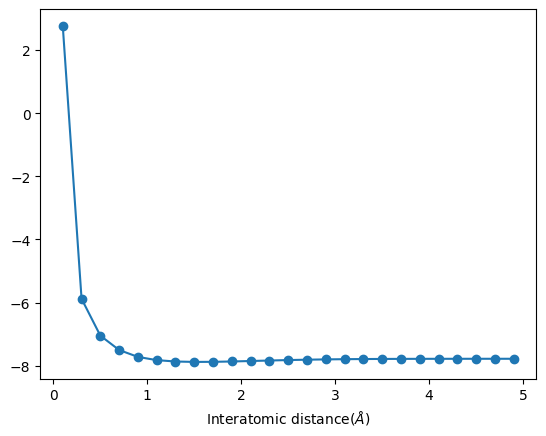

In [22]:
import matplotlib.pyplot as plt

# 生成横坐标的值
x = [0.1 + 0.2*i for i in range(len(c))]

# 绘制图形
plt.plot(x, c, marker='o', linestyle='-')

# 设置标题和标签

plt.xlabel('Interatomic distance($\AA$)')

# 显示网格线
plt.grid(0)


# 显示图形
plt.show()
